In [37]:
import cassio

ASTRA_DB_APPLICATION_TOKEN = "AstraCS:kHbIygIgPtniwYIzRsZAAvUK:d5c77950270bf75d939b99184b79f9c59db80ffde982d24c75c4af336397a0a8"
ASTRA_DB_ID = "c2d3c0e3-b214-4042-8337-7f53fa6777bb"
cassio.init(token = ASTRA_DB_APPLICATION_TOKEN,database_id = ASTRA_DB_ID)

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/",
    "https://inference-docs.cerebras.ai/quickstart",
    "https://docs.smith.langchain.com/"
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 1000,chunk_overlap = 200)
texts = text_splitter.split_documents(doc_list)
texts

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/', 'title': 'LangGraph Studio', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='LangGraph Studio\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            \n              LangGraph Studio\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n        \n  \n    \n  \n  Home\n\n      \n\n\n\n          \n  \n    \n  \n  Tutorials\n\n        \n\n\n\n          \n  \n    \n  \n  How-to Guides\n\n        \n\n\n\n          \n  \n    \n  \n  Conceptual Guides\n\n        \n\n\n\n          \n  \n    \n  \n  Reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n    \n  \n    Home\n  \n\n    \n  \n\n\n\n\n\n    \

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
load_dotenv()

embeddings = HuggingFaceEmbeddings(model_name = 'all-MiniLM-L6-v2')

In [6]:
from langchain.vectorstores.cassandra import Cassandra

astra_vector_store = Cassandra(embedding=embeddings,table_name = "qa_mini_demo",session=None,keyspace=None)

from langchain.indexes.vectorstore import VectorStoreIndexWrapper
print("Inserted %i headlines :" % len(texts))
astra_vector_store.add_documents(doc_list)


Inserted 10 headlines :


['3b43e8aa9734457196f09ade4ec8a332',
 '0b214376475840de829bcb6a3b1e1608',
 'c4ea9de519d74e4791cf4203eff0a408']

In [15]:
from IPython.display import Markdown
retriever = astra_vector_store.as_retriever()
response = retriever.invoke("What is an agent?")
response

[Document(id='c4ea9de519d74e4791cf4203eff0a408', metadata={'description': "LangSmith is a platform for building production-grade LLM applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Use of LangChain's open source frameworks is not necessary - LangSmith works on its own!", 'language': 'en', 'source': 'https://docs.smith.langchain.com/', 'title': 'Get started with LangSmith | \uf8ffü¶úÔ∏è\uf8ffüõ†Ô∏è LangSmith'}, page_content='\n\n\n\n\nGet started with LangSmith | \uf8ffü¶úÔ∏è\uf8ffüõ†Ô∏è LangSmith\n\n\n\n\n\n\nSkip to main contentGo to API DocsSearchRegionUSEUGo to AppQuick StartObservabilityEvaluationPrompt EngineeringDeployment (LangGraph Cloud)AdministrationSelf-hostingReferenceQuick StartOn this pageGet started with LangSmith\nLangSmith is a platform for building production-grade LLM applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Use 

In [16]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field

class RouteQuery(BaseModel):
    datasource: Literal["vectorstore","wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or vectorstore."
    )

In [17]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
import os
groq_api_key = os.getenv("GROQ_API_KEY") 
llm = ChatGroq(model_name = "llama3-groq-70b-8192-tool-use-preview",api_key=groq_api_key)

In [18]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [21]:
system = """You are an expert at routing a user question to a vectorstore or wikipedia.The vectorstore contains documents related to langgraph,cerebras and langsmith.Use the vectorstore for questions on these topics.Otherwise , use wiki search
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

In [ ]:
response_1 = question_router.invoke(
    {
        "question" : "What is langgraph?"
    }
)

In [ ]:
response_1

RouteQuery(datasource='vectorstore')

In [24]:
response_2 = question_router.invoke(
    {
        "question":"Who is gautam adani"
    }
)
response_2

RouteQuery(datasource='wiki_search')

# Importing wikipedia tools

In [26]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import  WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)


# now the agentic workflow using langgraph

In [27]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """ 
    Represents the state of our graph

    Attributes:
    question:question
    generation: LLM Generation
    documents:list of documents
    """
    question:str
    generation:str
    documents:List[str]

In [29]:
from langchain.schema import Document

def retrieve(state):
    """ 
    Retrieve documents

    Args:
      state (dict): The state of the task.
    Returns:
      state(dict): new key added to state,documents,that contains retrieved documents
      """
    print("----Retrieve----")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents,"question":question}
    

In [31]:
from langchain.schema import Document

def wiki_search(state):
    """ 
    wiki search based on the re-phrased question

    Args:
      state (dict): The state of the task.
    Returns:
      state(dict): Updated documents key with appended web results
      """
    
    print("----wikipedia----")
    question = state["question"]
    print(question)
    docs = wiki_tool.invoke({"query":question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents":wiki_results,"question":question}
    

In [32]:
def route_question(state):
    """ 
    Route question to wiki search or RAG

    Args:
    state(dict): The current graph state 

    Returns:
    str:Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question":question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO WIKI SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"



In [33]:
from langgraph.graph import END,StateGraph,START

workflow = StateGraph(GraphState)

workflow.add_node("wiki_search",wiki_search)
workflow.add_node("retrieve",retrieve)
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
        }
)
workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

app = workflow.compile()

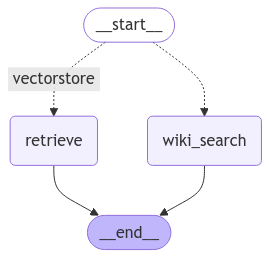

In [35]:
from IPython.display import Image,display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("The exception raised is ",e)

In [45]:
from pprint import pprint

inputs = {
    "question": "who is saurav gangully?"
}

# Stream the output and print the full response
for output in app.stream(inputs):
    pprint(output)  # Print the entire response for debugging
    for key, value in output.items():
        pprint(f"Node '{key}':")
        if 'documents' in value and len(value['documents']) > 0:
            document = value['documents'][0]
            pprint(document.dict().get('metadata', {}).get('description', 'No description available'))
    pprint("\n---\n")

---ROUTE QUESTION---
---ROUTE QUESTION TO WIKI SEARCH---
----wikipedia----
who is saurav gangully?
{'wiki_search': {'documents': Document(metadata={}, page_content='Page: Sourav Ganguly\nSummary: Sourav Chandidas Ganguly ( ; natively spelled as Gangopadhyay; born 8 July 1972), also known as Dada (meaning "elder brother" in Bengali), is an Indian cricket commentato'),
                 'question': 'who is saurav gangully?'}}
"Node 'wiki_search':"


TypeError: object of type 'Document' has no len()